In [3]:
# Importing Libraries

from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from causalnex.discretiser.discretiser_strategy import DecisionTreeSupervisedDiscretiserMethod
from causalnex.utils.network_utils import get_markov_blanket
from causalnex.evaluation import classification_report 
from causalnex.structure.notears import from_pandas
from causalnex.plots import NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork
import joblib

import numpy as np
import seaborn as sns
import os, sys, warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")

In [2]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from plots import Plots
plot = Plots()

2022-07-02 10:01:51,634 — FileHandler — DEBUG — Loaded successfully!
2022-07-02 10:01:51,652 — Plot — DEBUG — Loaded successfully!


In [28]:
file_handler = FileHandler()
data_feat = file_handler.read_csv("../data/features_data.csv") 
total_data_df = file_handler.read_csv("../data/cleaned_data.csv") 

2022-07-02 10:24:32,499 — FileHandler — DEBUG — file read as csv
2022-07-02 10:24:32,504 — FileHandler — DEBUG — file read as csv


#### Label Encode the string `diagnosis` column

In [29]:
# Label encode the string value: diagnosis

encoder = preprocessing.LabelEncoder()    
diagnosis = np.float64(encoder.fit_transform(data_feat['diagnosis']))

### Scale and Normalize the Data
For creating an effective casual graph model, all the numeric columns are normalized and scaled.

In [30]:
# Scale and normalize the features except our target, diagnosis

data_feat = file_handler.scale_and_normalize(data_feat[data_feat.columns.difference(['diagnosis'])])
total_data_df = file_handler.scale_and_normalize(total_data_df[total_data_df.columns.difference(['diagnosis'])]) 

In [31]:
# Bring back `diagnosis` to the dataframe

data_feat.insert(loc=0, column='diagnosis', value=diagnosis)
total_data_df.insert(loc=0, column='diagnosis', value=diagnosis)


### Create a causal graph using all training data (this will be considered as a ground truth)

We can apply now the NOTEARS algorithm to learn the structure.

In [278]:
%%time
sm = from_pandas(data_feat, tabu_parent_nodes=['diagnosis'],)


CPU times: user 25.8 s, sys: 47.6 s, total: 1min 13s
Wall time: 10.6 s


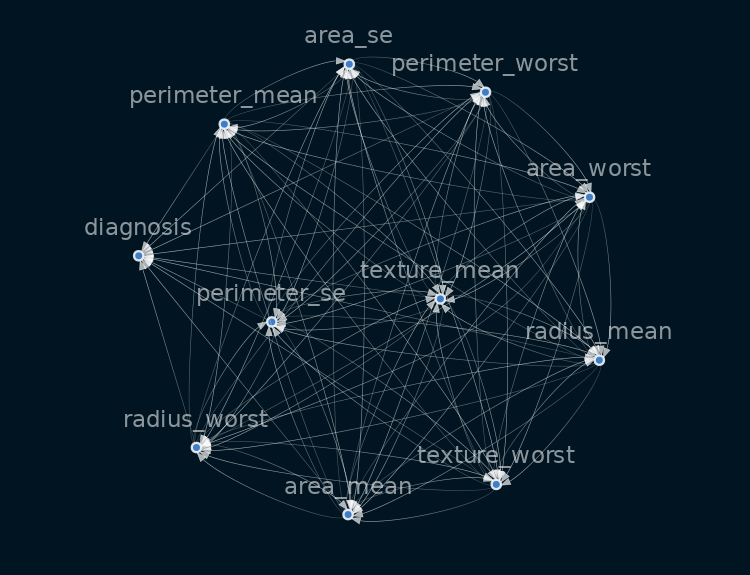

In [279]:
plot.vis_sm(sm)

Select optimal threshold that keeps the important edge connections => 0.8

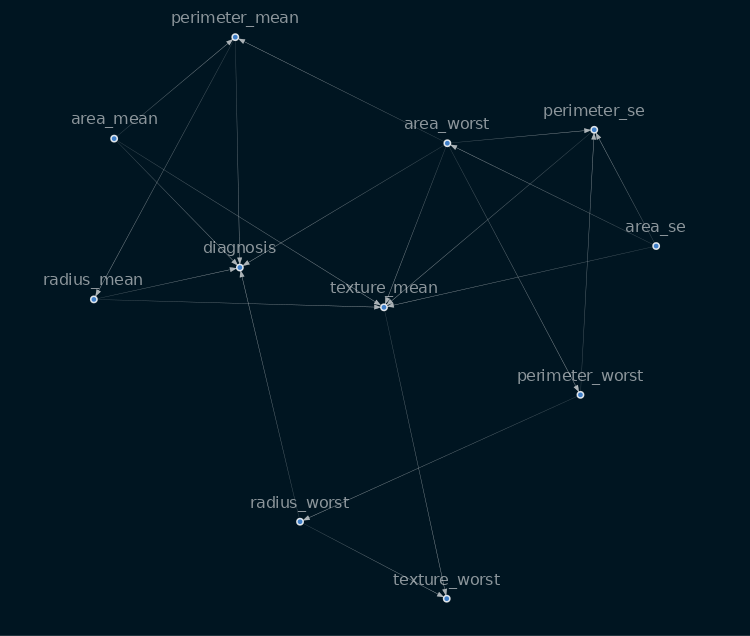

In [280]:
sm.remove_edges_below_threshold(0.80)
plot.vis_sm(sm)

## Stablity of Causal Graph

### 50%

CPU times: user 37.9 s, sys: 1min 6s, total: 1min 44s
Wall time: 13.8 s


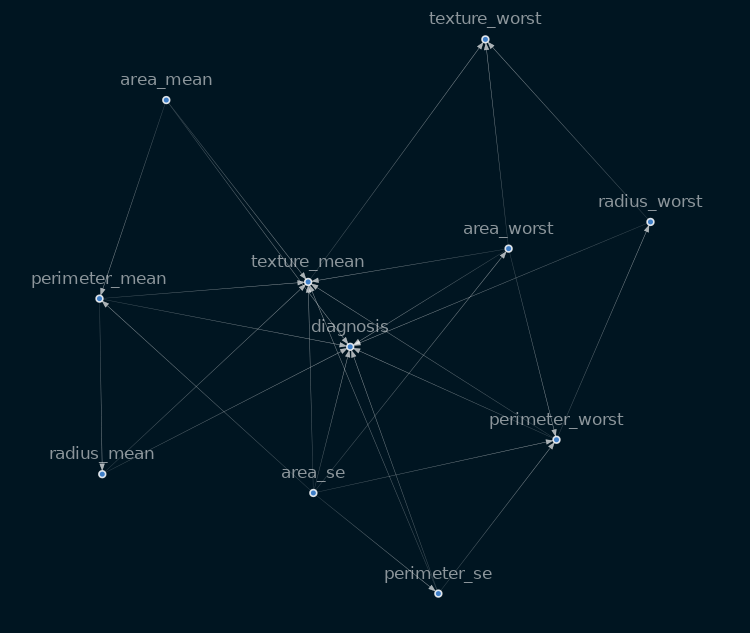

In [281]:
%%time
sm1 = plot.causal_graph(data_feat, 'diagnosis', 0.5)
plot.vis_sm(sm1)

In [282]:
print(sm1.edges)

[('area_worst', 'diagnosis'), ('area_worst', 'perimeter_worst'), ('area_worst', 'texture_worst'), ('area_worst', 'texture_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'perimeter_mean'), ('area_mean', 'texture_mean'), ('area_se', 'diagnosis'), ('area_se', 'area_worst'), ('area_se', 'perimeter_worst'), ('area_se', 'perimeter_mean'), ('area_se', 'perimeter_se'), ('area_se', 'texture_mean'), ('perimeter_worst', 'diagnosis'), ('perimeter_worst', 'radius_worst'), ('perimeter_worst', 'texture_mean'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'radius_mean'), ('perimeter_mean', 'texture_mean'), ('radius_worst', 'diagnosis'), ('radius_worst', 'texture_worst'), ('radius_mean', 'diagnosis'), ('radius_mean', 'texture_mean'), ('perimeter_se', 'diagnosis'), ('perimeter_se', 'perimeter_worst'), ('perimeter_se', 'texture_mean'), ('texture_mean', 'texture_worst')]


### 60%

CPU times: user 47 s, sys: 1min 25s, total: 2min 12s
Wall time: 18.2 s


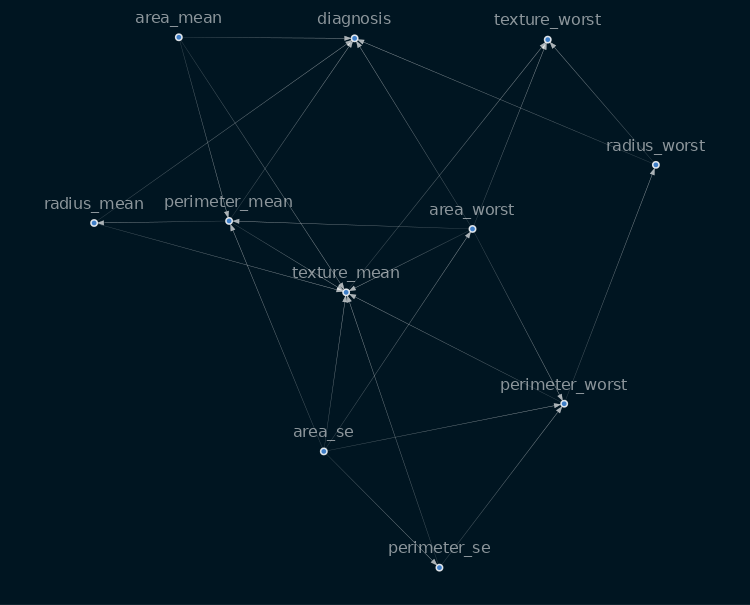

In [283]:
%%time
sm2 = plot.causal_graph(data_feat, 'diagnosis', 0.6)
plot.vis_sm(sm2)

In [284]:
print(sm2.edges)

[('area_worst', 'diagnosis'), ('area_worst', 'perimeter_worst'), ('area_worst', 'perimeter_mean'), ('area_worst', 'texture_worst'), ('area_worst', 'texture_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'perimeter_mean'), ('area_mean', 'texture_mean'), ('area_se', 'area_worst'), ('area_se', 'perimeter_worst'), ('area_se', 'perimeter_mean'), ('area_se', 'perimeter_se'), ('area_se', 'texture_mean'), ('perimeter_worst', 'radius_worst'), ('perimeter_worst', 'texture_mean'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'radius_mean'), ('perimeter_mean', 'texture_mean'), ('radius_worst', 'diagnosis'), ('radius_worst', 'texture_worst'), ('radius_mean', 'diagnosis'), ('radius_mean', 'texture_mean'), ('perimeter_se', 'perimeter_worst'), ('perimeter_se', 'texture_mean'), ('texture_mean', 'texture_worst')]


#### Jaccard Similarity Index
The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations.
It follows the following equation to compute the similarity between two graphs. 

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|} = \frac{|A \cap B|}{|A|+|B|- |A \cap B|}

In [13]:
def jaccard_similarity(A, B):
    """
    Calculate the Jaccard similarity between two given graphs.
    Parameters:
        A: graph 1
        B: graph 2  
    """
    i = set(A).intersection(B)
    return round(len(i) / (len(A) + len(B) - len(i)), 3)

In [286]:
jaccard_similarity(sm1.edges, sm2.edges)

0.857

### 70%

CPU times: user 37.5 s, sys: 1min 7s, total: 1min 45s
Wall time: 14.7 s


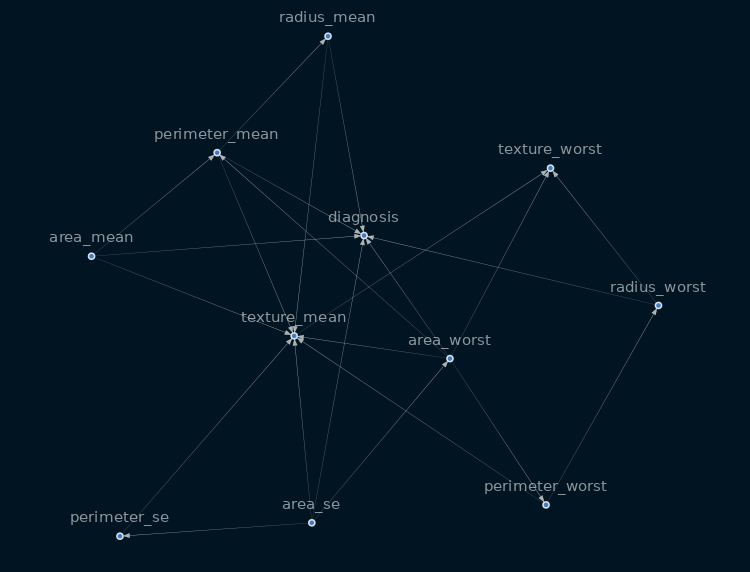

In [287]:
%%time
sm3 = plot.causal_graph(data_feat, 'diagnosis', 0.7)
plot.vis_sm(sm3)

In [288]:
print(sm3.edges)

[('area_worst', 'diagnosis'), ('area_worst', 'perimeter_worst'), ('area_worst', 'perimeter_mean'), ('area_worst', 'texture_worst'), ('area_worst', 'texture_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'perimeter_mean'), ('area_mean', 'texture_mean'), ('area_se', 'diagnosis'), ('area_se', 'area_worst'), ('area_se', 'perimeter_se'), ('area_se', 'texture_mean'), ('perimeter_worst', 'radius_worst'), ('perimeter_worst', 'texture_mean'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'radius_mean'), ('perimeter_mean', 'texture_mean'), ('radius_worst', 'diagnosis'), ('radius_worst', 'texture_worst'), ('radius_mean', 'diagnosis'), ('radius_mean', 'texture_mean'), ('perimeter_se', 'texture_mean'), ('texture_mean', 'texture_worst')]


In [289]:
jaccard_similarity(sm2.edges, sm3.edges)

0.846

### 80%

CPU times: user 40.6 s, sys: 1min 14s, total: 1min 55s
Wall time: 16.1 s


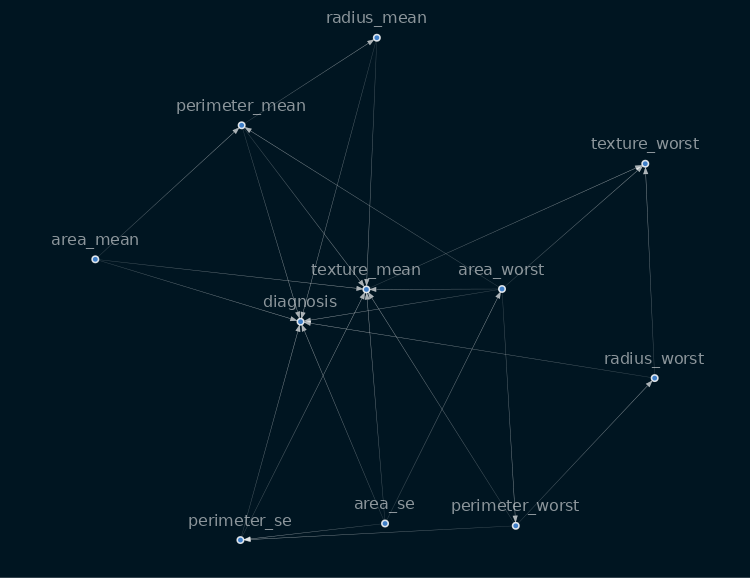

In [290]:
%%time
sm4 = plot.causal_graph(data_feat, 'diagnosis', 0.8)
plot.vis_sm(sm4)

In [291]:
print(sm4.edges)

[('area_worst', 'diagnosis'), ('area_worst', 'perimeter_worst'), ('area_worst', 'perimeter_mean'), ('area_worst', 'texture_worst'), ('area_worst', 'texture_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'perimeter_mean'), ('area_mean', 'texture_mean'), ('area_se', 'diagnosis'), ('area_se', 'area_worst'), ('area_se', 'perimeter_se'), ('area_se', 'texture_mean'), ('perimeter_worst', 'radius_worst'), ('perimeter_worst', 'perimeter_se'), ('perimeter_worst', 'texture_mean'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'radius_mean'), ('perimeter_mean', 'texture_mean'), ('radius_worst', 'diagnosis'), ('radius_worst', 'texture_worst'), ('radius_mean', 'diagnosis'), ('radius_mean', 'texture_mean'), ('perimeter_se', 'diagnosis'), ('perimeter_se', 'texture_mean'), ('texture_mean', 'texture_worst')]


In [292]:
jaccard_similarity(sm3.edges, sm4.edges)

0.92

### 90%

CPU times: user 24.5 s, sys: 45 s, total: 1min 9s
Wall time: 9.57 s


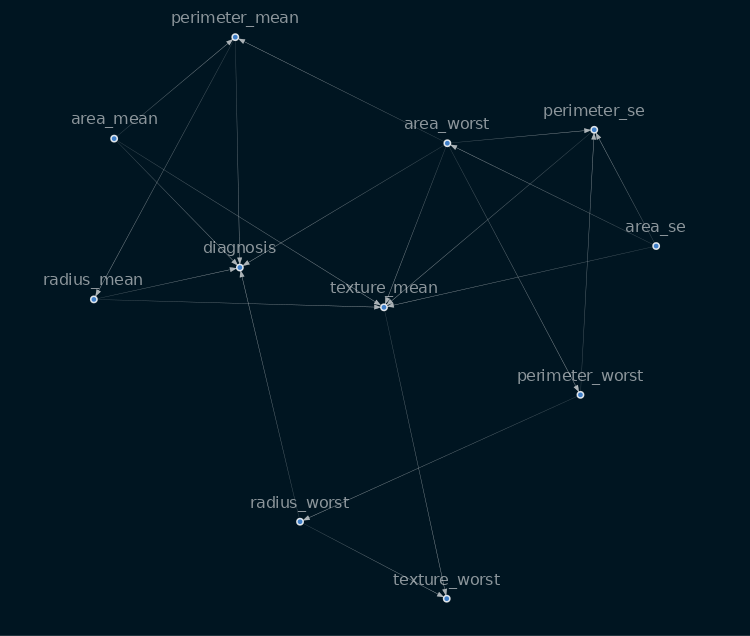

In [10]:
%%time
sm5 = plot.causal_graph(data_feat, 'diagnosis', 0.9)
plot.vis_sm(sm5)

In [294]:
print(sm5.edges)

[('area_worst', 'diagnosis'), ('area_worst', 'perimeter_worst'), ('area_worst', 'perimeter_mean'), ('area_worst', 'perimeter_se'), ('area_worst', 'texture_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'perimeter_mean'), ('area_mean', 'texture_mean'), ('area_se', 'area_worst'), ('area_se', 'perimeter_se'), ('area_se', 'texture_mean'), ('perimeter_worst', 'radius_worst'), ('perimeter_worst', 'perimeter_se'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'radius_mean'), ('radius_worst', 'diagnosis'), ('radius_worst', 'texture_worst'), ('radius_mean', 'diagnosis'), ('radius_mean', 'texture_mean'), ('perimeter_se', 'texture_mean'), ('texture_mean', 'texture_worst')]


In [295]:
jaccard_similarity(sm4.edges, sm5.edges)

0.769

### 100%

CPU times: user 24.4 s, sys: 44 s, total: 1min 8s
Wall time: 9.15 s


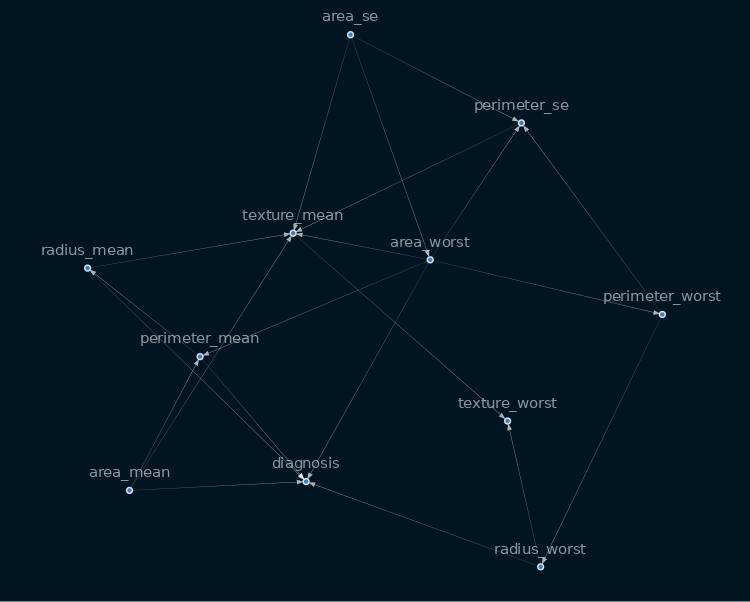

In [8]:
%%time
sm = plot.causal_graph(data_feat, 'diagnosis', 1.0)
plot.vis_sm(sm)

In [297]:
print(sm.edges)

[('area_worst', 'diagnosis'), ('area_worst', 'perimeter_worst'), ('area_worst', 'perimeter_mean'), ('area_worst', 'perimeter_se'), ('area_worst', 'texture_mean'), ('area_mean', 'diagnosis'), ('area_mean', 'perimeter_mean'), ('area_mean', 'texture_mean'), ('area_se', 'area_worst'), ('area_se', 'perimeter_se'), ('area_se', 'texture_mean'), ('perimeter_worst', 'radius_worst'), ('perimeter_worst', 'perimeter_se'), ('perimeter_mean', 'diagnosis'), ('perimeter_mean', 'radius_mean'), ('radius_worst', 'diagnosis'), ('radius_worst', 'texture_worst'), ('radius_mean', 'diagnosis'), ('radius_mean', 'texture_mean'), ('perimeter_se', 'texture_mean'), ('texture_mean', 'texture_worst')]


In [14]:
jaccard_similarity(sm5.edges, sm.edges)

1.0

### Reducing a Graph to its Markov Blanket

The Markov blanket (MB) of a variable is the subset of nodes in the Bayesian Network that contain all the useful information for predicting that variable. In other words, nodes outside a variable’s MB will (given knowledge of the nodes in the MB) have absolutely no influence on the variable of interest.

`diagnosis` is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the `get_markov_blanket` function from `causalnex`.

In [9]:
bn = BayesianNetwork(sm)
blanket = get_markov_blanket(bn, 'diagnosis')
edge_list = list(blanket.structure.edges)
edge_list

[('area_mean', 'diagnosis'),
 ('area_mean', 'perimeter_mean'),
 ('area_worst', 'diagnosis'),
 ('area_worst', 'perimeter_mean'),
 ('perimeter_mean', 'diagnosis'),
 ('perimeter_mean', 'radius_mean'),
 ('radius_mean', 'diagnosis'),
 ('radius_worst', 'diagnosis')]

The number of the input features after applying markov blanket is reduced to five. The resulting casual graph is the following.

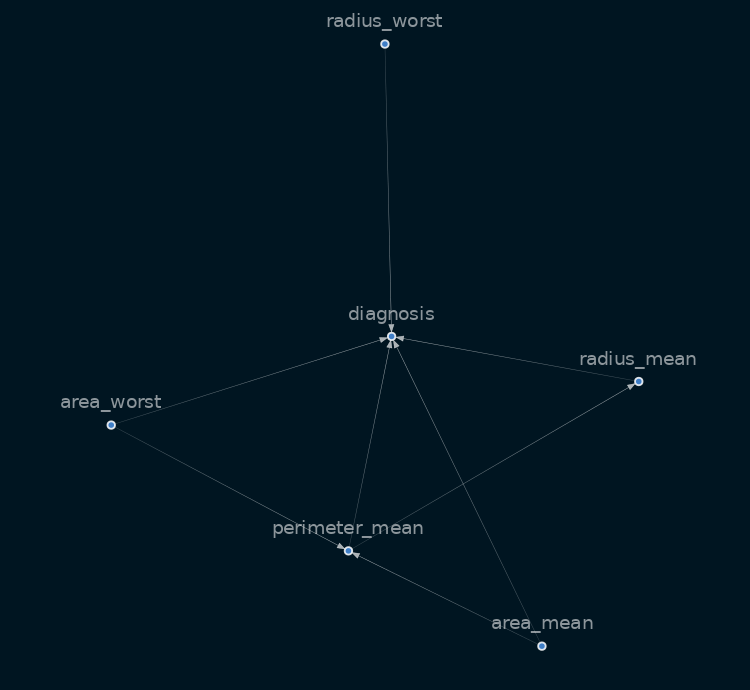

In [10]:
plot.vis_sm(blanket.structure)

### Trainning a model using all variables


#### Fitting Bayesian Network
Bayesian Networks represents dependencies between variables and their joint distribution. Bayesian Network is directed acyclic graph, where nodes are random variables and edges are causal connections between variables and represent conditional probability distribution. Once we have a structural model, we create our Bayesian Network and fit conditional probabilities

CasualNex provides BayesianNetwork implementation that we are going to use. But the BayesianNetwork implementation expects all its features to be discrete values. To discretizing our features, we used DecisionTreeSupervisedDiscretiserMethod provided by CasualNex.

In [61]:
def discretizer(features, df_feat):
    """
    This function transforms continous data into discrete values
    """
    tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
        mode='single',
        tree_params={'max_depth': 3, 'random_state': 27},
    )
    tree_discretiser.fit(
        feat_names=features,
        dataframe=df_feat,
        target_continuous=True,
        target='diagnosis',
    )
    discretised_data = df_feat.copy()
    for col in features:
        discretised_data[col] = tree_discretiser.transform(df_feat[[col]])
    return discretised_data


In [62]:
def bayesian_model(bn, discretised_data):
    """
    parameters:
        - A Markov Blanket object
        - A BayesianNetwork object
    return:
        - A BayesianNetwork Model
    """
    train, test = train_test_split(discretised_data, train_size=0.8, test_size=0.2, random_state=27)    
    bn = BayesianNetwork(bn.structure)
    bn = bn.fit_node_states(discretised_data)
    bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")
    return bn, test

In [63]:
def classification_report(model, test_data):
    """
    This function generates a classification report; recall, f1 score, accuray, and precision 
    based on the the prediction of the test_data by the model
    """
    pred = model.predict(test_data, 'diagnosis')
    true = test['diagnosis']
    
    print(' Recall:   {:.2f}'.format(recall_score(y_true=true, y_pred=pred)), '\n----------------')
    print(' F1 Score: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)), '\n----------------')
    print(' Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)), '\n----------------')
    print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)), '\n----------------')

In [64]:
discretised_data = discretizer(data_feat, total_data_df)
discretised_data.head()

,diagnosis,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
0,1,3,7,6,0.283987,0.125995,0.222048,0.262142,0.107790,0.327010,...,4,0.212891,0.057116,0.215539,0.246097,0.111741,0.214580,0,0.043195,0
1,1,6,6,7,0.099095,0.044335,0.084263,0.190132,0.138384,0.348459,...,7,0.158034,0.065086,0.189476,0.207055,0.046088,0.127346,0,0.045025,2
2,1,4,6,6,0.190056,0.125210,0.169931,0.280305,0.171902,0.368215,...,5,0.226784,0.066509,0.213238,0.224706,0.090699,0.178014,0,0.041583,2
3,1,0,1,0,0.264676,0.177204,0.265541,0.170564,0.115370,0.288659,...,1,0.264663,0.082027,0.298639,0.253227,0.237531,0.326213,0,0.057373,0
4,1,6,7,7,0.177728,0.085784,0.088082,0.264830,0.182419,0.285279,...,7,0.219853,0.169792,0.223436,0.193253,0.069570,0.080462,0,0.047544,0


In [65]:
model, test = bayesian_model(blanket, discretised_data)

In [66]:
classification_report(model, test)

 Recall:   0.49 
----------------
 F1 Score: 0.66  
----------------
 Accuracy: 0.80  
----------------
Precision: 1.00  
----------------


**Save the Model**

In [67]:
joblib.dump(model, "../models/bayesian_model_1.pkl") 

['../models/bayesian_model_1.pkl']